# Question #1:
Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### Library and Data Import

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('ggplot')
import sqlite3
from pandasql import sqldf

#Pulling functions generated throughout the course of the module to assist with some of the testing.
from flatiron_stats import *

#Setting significance level:
a = 0.05

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

### Hypothesis 1
H0: Discount Amount has no statistically significant effect on the quantity of a product in an order.<br>
HA: Discount Amount does have a statistically significant effect on the quantity of a product in an order.<br>

### Gathering Data
Starting with a quick summary query to investigate each discount level for minimum, maximum, and average quantity ordered, as well as how many total orders to ensure there's enough data to evaluate.

In [3]:
query = """SELECT Discount, ROUND(avg(Quantity),2) AS AvgQuantity,
                  MIN(Quantity) AS MinQuantity, MAX(Quantity) AS MaxQuantity,
                  COUNT(*) AS TotalOrders
           FROM OrderDetail
           GROUP BY Discount
           """
pd.read_sql(query,conn)

,Discount,AvgQuantity,MinQuantity,MaxQuantity,TotalOrders
0,0.00,21.72,1,130,1317
1,0.01,2.00,2,2,1
2,0.02,2.00,1,3,2
3,0.03,1.67,1,2,3
4,0.04,1.00,1,1,1
5,0.05,28.01,1,120,185
6,0.06,2.00,2,2,1
7,0.10,25.24,2,130,173
8,0.15,28.38,2,100,157
9,0.20,27.02,2,100,161


Initial review indicates that there is at least some effect for most of the discount levels, however, some of them do not have enough data to properly evaluate. Generating a dataframe from the Order Details table as it contains all of the data we need, and dropping the discount levels where the Total Orders is fewer than 10 along with unnecessary columns such as UnitPrice and ProductID.

In [4]:
query = """SELECT OrderID, Quantity, Discount FROM OrderDetail
           WHERE Discount IN (0.00, 0.05, 0.10, 0.15, 0.20, 0.25)"""
df = pd.read_sql(query,conn)
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

### Visualizing the Data
Exploring the data visually to understand the range of each discount level.

Text(0, 0.5, 'Quantity Ordered')

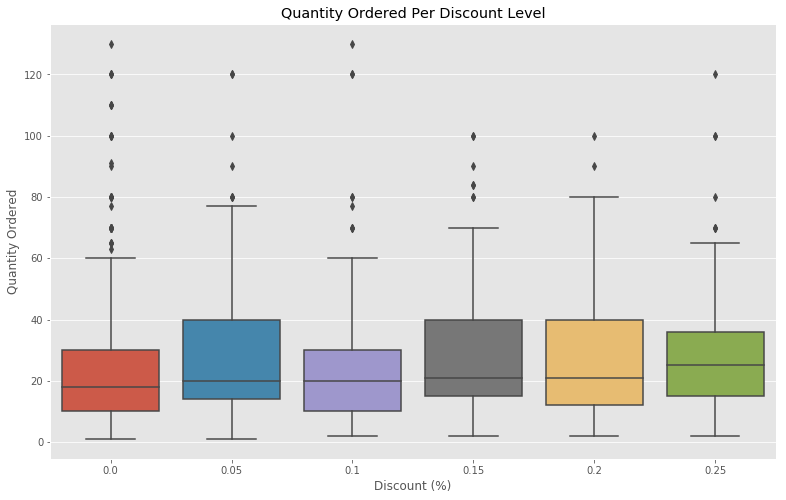

In [5]:
plt.figure(figsize = (13, 8))
sns.boxplot(x='Discount',y='Quantity',data=df)
plt.title('Quantity Ordered Per Discount Level')
plt.xlabel('Discount (%)');
plt.ylabel('Quantity Ordered')

### Hypothesis Testing
Since the visualizations and table show that there does appear to be a difference, we'll move on to testing to determine whether or not that difference is of a statistical significance. To answer the first question (Is there a statistically significant difference between discounted or not) we'll do an ANOVA test, comparing all discount levels to the non-discounted orders.

To restate, our hypothesis is: <br>
H0: Discount Amount has no statistically significant effect on the quantity of a product in an order.<br>
HA: Discount Amount does have a statistically significant effect on the quantity of a product in an order.<br>

In [6]:
formula = "Quantity ~ C(Discount)"
lm = smf.ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(Discount)   17348.854662     5.0  9.798709  2.840681e-09
Residual     758138.565924  2141.0       NaN           NaN


With a P-Value significantly lower than our Alpha set above, we can reject our Null Hypothesis and say that there does appear to be a statistically significant difference in quantity ordered when a discount is applied. To figure out which discount level has the largest difference, we'll move on to Tukey testing, comparing each discount level against the non-discounted level. 

Our Null Hypothesis for this test is similar to our overall Null Hypothesis, but is looking at each specific level of discount rather than only comparing discounted and not.

In [7]:
tk = smc.MultiComparison(df['Quantity'], df['Discount'])
result = tk.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.05   6.2955   2.0814 10.5097  True 
 0.0    0.1    3.5217  -0.8187  7.8622 False 
 0.0    0.15   6.6669   2.1352 11.1986  True 
 0.0    0.2    5.3096   0.8285  9.7907  True 
 0.0    0.25   6.525    1.954   11.096  True 
 0.05   0.1   -2.7738  -8.4504  2.9028 False 
 0.05   0.15   0.3714  -5.4528  6.1955 False 
 0.05   0.2    -0.986  -6.7708  4.7989 False 
 0.05   0.25   0.2294  -5.6253  6.0842 False 
 0.1    0.15   3.1452   -2.771  9.0613 False 
 0.1    0.2    1.7879  -4.0896  7.6653 False 
 0.1    0.25   3.0033   -2.943  8.9496 False 
 0.15   0.2   -1.3573  -7.3775  4.6628 False 
 0.15   0.25  -0.1419  -6.2292  5.9454 False 
 0.2    0.25   1.2154  -4.8343  7.2652 False 
---------------------------------------------


Based on this test, no particular discount level is statistically significantly different from any other, however, the 5%, 15%, 20%, and 25% discount levels all show a statistically significant difference from the non-discounted orders, while 10% does not. Our Null Hypothesis can be rejected for four of the five discount levels.

### Which Discount Level is Best?
Now that we know that four of our five primary discount levels are indeed statistically significant, we need to dig in to determine which level(s) provide the highest increase in order quantity.

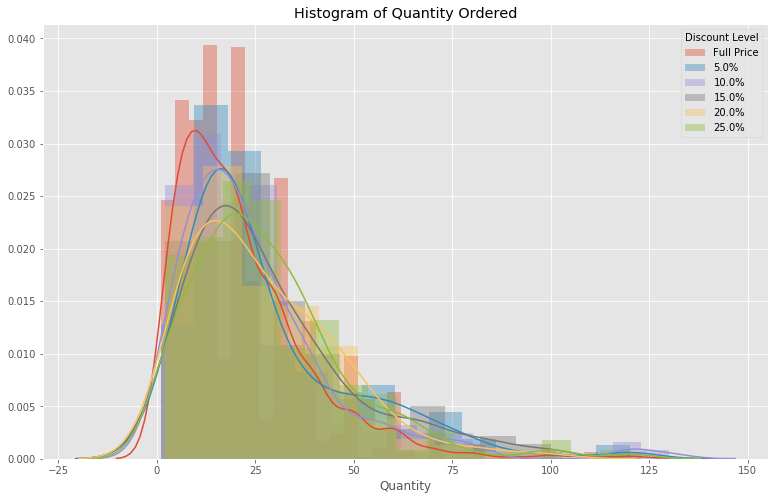

In [8]:
discount_levels = list(df.Discount.unique())
discount_levels.sort()
plt.figure(figsize = (13, 8))

for discount_level in discount_levels:
    if discount_level == 0.0:
        sns.distplot(df.Quantity[df.Discount==discount_level], label='Full Price')
    else:
        sns.distplot(df.Quantity[df.Discount==discount_level], label=f'{discount_level*100}%')
plt.title('Histogram of Quantity Ordered')
plt.legend(title = 'Discount Level')

While there is a hint of normality to each distribution, they all have some degree of positive skew. To determine normality, we'll run KS (Kolmogorov-Smirnov) and Shapiro tests, sticking to our significance value of 0.05.

In [9]:
for level in discount_levels:
    quantity = df.Quantity[df.Discount == level]
    mu = quantity.mean()
    std = quantity.std()
    stat, p = stats.kstest(quantity, 'norm', args = (mu, std))
    print(f"KS Test for Discount Level {level}:\nTest Statistic: {stat}\nP-Value: {p}\nIs Normal: {p > a}\n")

KS Test for Discount Level 0.0:
Test Statistic: 0.1571445192364258
P-Value: 0.0
Is Normal: False

KS Test for Discount Level 0.05:
Test Statistic: 0.20313023748048237
P-Value: 3.6069640252378576e-07
Is Normal: False

KS Test for Discount Level 0.1:
Test Statistic: 0.1740680758662153
P-Value: 4.6985238253416384e-05
Is Normal: False

KS Test for Discount Level 0.15:
Test Statistic: 0.15071200564575948
P-Value: 0.00140682333660469
Is Normal: False

KS Test for Discount Level 0.2:
Test Statistic: 0.13611315921798217
P-Value: 0.004607024469823973
Is Normal: False

KS Test for Discount Level 0.25:
Test Statistic: 0.14047770883428667
P-Value: 0.004098415545314316
Is Normal: False



In [10]:
for level in discount_levels:
    quantity = df.Quantity[df.Discount == level]
    stat, p = stats.shapiro(quantity)
    print(f"Shapiro Test for Discount Level {level}:\nTest Statistic: {stat}\nP-Value: {p}\nIs Normal: {p > a}\n")

Shapiro Test for Discount Level 0.0:
Test Statistic: 0.8434571027755737
P-Value: 3.803856556577728e-34
Is Normal: False

Shapiro Test for Discount Level 0.05:
Test Statistic: 0.8356332778930664
P-Value: 3.5543719660233175e-13
Is Normal: False

Shapiro Test for Discount Level 0.1:
Test Statistic: 0.8002723455429077
P-Value: 4.159971249851485e-14
Is Normal: False

Shapiro Test for Discount Level 0.15:
Test Statistic: 0.8827876448631287
P-Value: 8.372069704165597e-10
Is Normal: False

Shapiro Test for Discount Level 0.2:
Test Statistic: 0.9130357503890991
P-Value: 3.249125413162801e-08
Is Normal: False

Shapiro Test for Discount Level 0.25:
Test Statistic: 0.8902021646499634
P-Value: 2.6962121424389807e-09
Is Normal: False



Both tests indicate that none of the distributions are normal. While a Welch's T-Test is doable with non-normal distributions, in order to better compare each level's effect size, we'll take a number of samples to gather a more normal distribution for each level based on the Central Limit Theorem.

### Sampling and Reviewing

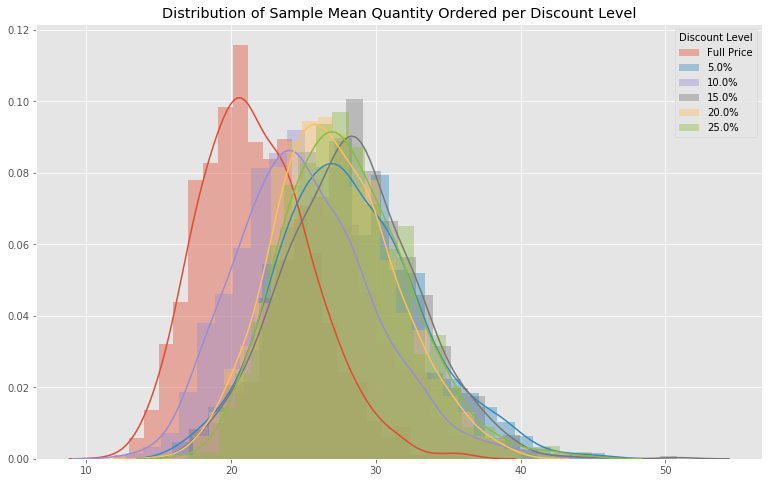

In [22]:
num_samples = 1000
sample_size = 20
plt.figure(figsize = (13, 8))
samp_dict = {}
for level in discount_levels:
    quantity = df.Quantity[df.Discount == level]
    samp_means = []
    for n in range(num_samples):
        sample = np.random.choice(quantity, size = sample_size, replace = True)
        samp_means.append(sample.mean())
    samp_dict[level] = np.array(samp_means)
    label = f'{level*100}%'
    if level == 0.00:
        label = 'Full Price'
    sns.distplot(samp_means, label = label)
plt.title('Distribution of Sample Mean Quantity Ordered per Discount Level')
plt.legend(title = 'Discount Level')

As these samples look much more normal, let's finally dig in to the overall benefit of each discount level by determining each discount level's effect size compared to the full price orders.

### Effect Size

In [27]:
#Sample Group Effect Sizes
for level in discount_levels:
    full_price = samp_dict[0.00]
    if level != 0.00:
        d = cohens_d(full_price, samp_dict[level])
        print(f'Effect Size (d) for Discount Level {level*100}%: {np.abs(d)}')

Effect Size (d) for Discount Level 5.0%: 1.449901660625435
Effect Size (d) for Discount Level 10.0%: 0.7906985124409258
Effect Size (d) for Discount Level 15.0%: 1.5557912351179988
Effect Size (d) for Discount Level 20.0%: 1.3523624132972651
Effect Size (d) for Discount Level 25.0%: 1.5240289749174045


In [28]:
#Original Data Effect Sizes
for level in discount_levels:
    full_price = df.Quantity[df.Discount == 0]
    if level != 0.00:
        d = cohens_d(full_price, df.Quantity[df.Discount == level])
        print(f'Effect Size (d) for Discount Level {level*100}%: {np.abs(d)}')

Effect Size (d) for Discount Level 5.0%: 0.3468767736284544
Effect Size (d) for Discount Level 10.0%: 0.19594203057834086
Effect Size (d) for Discount Level 15.0%: 0.3724041317472808
Effect Size (d) for Discount Level 20.0%: 0.3007122542913553
Effect Size (d) for Discount Level 25.0%: 0.36659255652674416


## Conclusion
Based on the Effect Sizes above, the largest difference in quantity ordered is a discount of 15%, followed closely by 25%. Were I providing recommendations to a company, I would suggest that 5% and 15% would give them the biggest bang for their buck (or rather the largest effect for least reduction in price) and I would recommend avoiding the 10% discount altogether as it does not provide a statistically significant difference in quantity ordered.